Лекции: https://drive.google.com/drive/folders/1W_7LX8I5IlRmQTCPeXh_JiFlZws8U0_d

# <center> Лабораторная работа №1 </center>

In [41]:
import pandas as pd
from pathlib import Path
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Подключимся к google диску, чтобы в дальнейшем загружать туда и оттуда нужные файлы.

In [42]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
DATA_PATH = Path('/content/drive/My Drive/Laba_1/')

In [44]:
train = pq.read_table(DATA_PATH / 'train.parquet')
train = train.to_pandas()
train = train.reset_index()

train.head()

,Id,Body,Tags,Title,target
0,34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2
1,47303682,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2
2,46431243,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0
3,45306324,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0
4,49479547,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1


In [45]:
train.shape

(48000, 5)

*   target = 0 - качественные посты без единой правки
*   target = 1 - некачественные посты, закрытые без редактирования
*   target = 2 - некачественные посты с отрицательной оценкой и несколькими изменениями 

In [46]:
test = pq.read_table(DATA_PATH / 'test.parquet')
test = test.to_pandas()
test = test.reset_index()

test.head()

,Id,Body,Tags,Title
0,46785369,I was given a decision tree with sample data i...,<math><machine-learning><artificial-intelligen...,Desecion trees ended up with same given tree a...
1,38908667,<p>I am moving a test application over to Xcod...,<ios><swift><swift3><xcode8><nserror>,Value of type 'Error' has no member 'code'
2,44703012,<p>I would like to be able to perform linting ...,<jenkins><jenkins-pipeline>,How do I lint Jenkins pipelines from the comma...
3,34910435,"<p>I’m using <a href=""https://github.com/ftlab...",<javascript><css><mobile-safari><fastclick.js>...,Is there a way to prevent fastclick from firin...
4,51632121,I have some 5 Test cases and I want them to ke...,<android><testing><appium><katalon-studio>,How to loop test cases in katalon Studio?


In [47]:
test.shape

(12000, 4)

### 1. EDA (exploratory data analysis)

Для начала проверим, присутствуют ли в данных пропущенные значения, и если да, то где.

In [48]:
train.isnull().sum()

Id        0
Body      0
Tags      0
Title     0
target    0
dtype: int64

In [49]:
test.isnull().sum()

Id       0
Body     0
Tags     0
Title    0
dtype: int64

Пропущенных данных нет. Все 3 столбца наших данных (`Id` и `target` не берем в рассчет) являются вольным текстом. Столбец `Id` не несет никакой пользы, поэтому его можно удалить.

In [50]:
train.drop(['Id'], axis = 1, inplace = True)
test.drop(['Id'], axis = 1, inplace = True)

Построим круговую диаграмму баланса классов для `train`.

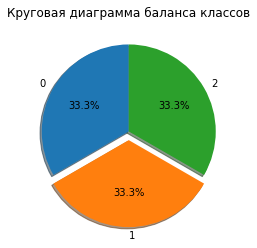

In [51]:
explode = (0, 0.1, 0)
labels = ['0', '1', '2']
sizes = [0, 0, 0]

for i in range(3):
  sizes[i] += len(train[train['target'] == i]) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title("Круговая диаграмма баланса классов")
plt.show()

В `train` у нас встречается равное количество разных целевых переменных.

Видим, что в остальных столбцах встречаются ненужные нам символы. Для начала попробует понять, с чем мы имеем дело.

In [52]:
train.iloc[0].Body

"Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n**output:** Set of MSTs T\r\n\r\n**begin**\r\n\r\nT=null;\r\nE=G.Edges;\r\n\r\nfor all vertices in G,\r\nCreate a tree t having single vertex b\r\n\r\nadd t to T\r\n\r\nend for\r\n\r\n     repeat\r\n        Find an edge e ∈ E having minimum weight\r\n        such that one end belongs to t ∈ T and the other\r\n        end does not belongs to any of the trees in T\r\n        Add e to t\r\n      until e = NULL\r\n\r\nI'm stuck on the logic for the highlighted block.\r\nI've used simple objects for vertex,edge and tree. And for their sets, used array of Objects.\r\n\r\n\r\n"

In [53]:
train.iloc[3].Body

'<p>Let say I have a component in Angular 2 that needs to load 2 different things from the server before the page is displayed.  I\'d like all of those things to fire off and call one event handler when they come back telling the page isLoaded = true. Let\'s say I have a service class that looks like this.</p>\n\n<pre><code>export class MyService {\n   getStronglyTypedData1(): Observable&lt;StrongData1[]&gt;{\n      return this.http.get(\'http://...\').map((response:Response) =&gt; &lt;StrongData1[]&gt;response.json());\n   }\n   getStronglyTypedData2(): Observable&lt;StrongData2[]&gt;{\n         return this.http.get(\'http://...\').map((response:Response) =&gt; &lt;StrongData2[]&gt;response.json());\n   }\n}\n</code></pre>\n\n<p>Then I have a component that uses that service class like this.</p>\n\n<pre><code>export class MyComponent implements OnInit {\n   isLoaded = false;\n   stronglyTypedData1: StrongData1[];\n   stronglyTypedData2: StrongData2[];\n\n   constructor(private myServi

В столбце `Body` встречаются теги, куски кода и знаки препинания. Будем удалять все теги, весь текст, которые содержится между < code> и  <\code>, знаки препинания, цифры.

In [54]:
train.iloc[0].Tags

'<java><algorithm><graph-algorithm>'

In [55]:
train.iloc[3].Tags

'<angular><typescript><rxjs>'

В столбце `Tags` встречаются символы `>` и `<`. Также заметим, что некоторые слова прописаны через `-`. Будем удалять '<', '>', слова через - будем разделять на отдельные слова.


In [56]:
train.iloc[3].Title

'Casting results from Observable.forkJoin to their respective types in Angular 2'

In [57]:
train.iloc[10].Title

"Why the compiler doesn't let me use for loop with a switch?"

В столбце `Title` встречаются знаки препинания и цифры. Будем их удалять.

Нам нужно попытаться максимально очистить наши данные от мусора (убрать код, знаки препинания, цифры и прочее). Воспользуемся библиотекой `re`. Так как нам надо очищать данные и в `train`, и в `test`, то для предотвращения дублирования создадим функцию.

In [58]:
import re
import time

In [59]:
def RemoveCharacters(data):

  t = time.time()

  body = []
  tags = []
  title = []

  for i in range (data.shape[0]):
    row = data.iloc[i]
    body.append(re.sub(r'\s\s+', ' ', re.sub(r'\b\w\b', '', re.sub(r"""\b\S+[._]\S+\b|\b\S+[A-Z]\S*\b|\n|\r|\t|<code>[\s\S]*</code>|</[^>]*>|<[^>]*>|\b\S*\d+\S*\b|[-!"'“”’#$%&()*+,./:;<=>?@[\]^_`{|}~∈]|\b\w\b""", ' ', row[0]))))
    tags.append(re.sub(r'[<>]|[.]', '', re.sub(r'><|-', ' ', row[1])))
    title.append(re.sub(r'\s\s+', ' ', re.sub(r"""\b\S+[._]\S+\b|\b\S*\d+\S*\b|[-!“”"'’#$%&()*+,./:;<=>?@[\]^_`{|}~]|\b\S+[A-Z]\S*\b""", ' ', row[2])))

  print (time.time()-t)

  return body, tags, title

Для `train`:

In [60]:
body_train, tags_train, title_train = RemoveCharacters(train)

15.644651651382446


In [61]:
body_train[238]

'hello and thank you very very much in advance for helping me with this have this array that is dumped from woocommerce using this lines items foreach items as item values booking year month day persons date date août time time min qty Personnes cost variation quantity total subtotal data id post La Cuchara publish open closed pinged guid product filter raw booking supports protected price no yes no taxable instock no what need to recover the booking date time and persons into variables date août persons time min '

Для `test`:

In [62]:
body_test, tags_test, title_test = RemoveCharacters(test)

3.295776605606079


In [63]:
tags_test[3]

'javascript css mobile safari fastclickjs fastclick'

Теперь разобьем наши необработанные тексты на последовательности токенов (в нашем случае слов).

In [64]:
import nltk

In [65]:
def Tokenize(body, tags, title):

  t = time.time()

  tokenizer = nltk.tokenize.WordPunctTokenizer()

  tokens_body = []
  tokens_tags = []
  tokens_title = []

  for i in range (len(body)):
    tokens_body.append (tokenizer.tokenize(body[i]))
    tokens_tags.append (tokenizer.tokenize(tags[i]))
    tokens_title.append (tokenizer.tokenize(title[i]))

  print(time.time()-t)

  return tokens_body, tokens_tags, tokens_title

In [66]:
tokens_body_train, tokens_tags_train, tokens_title_train = Tokenize(body_train, tags_train, title_train)

1.4408104419708252


In [67]:
tokens_body_test, tokens_tags_test, tokens_title_test = Tokenize(body_test, tags_test, title_test)

0.27876782417297363


In [68]:
tokens_body_test[0]

['was',
 'given',
 'decision',
 'tree',
 'with',
 'sample',
 'data',
 'in',
 'class',
 'to',
 'solve',
 'After',
 'computing',
 'the',
 'gaining',
 'splitting',
 'tree',
 'with',
 'the',
 'sample',
 'data',
 'provided',
 'ended',
 'up',
 'with',
 'the',
 'same',
 'tree',
 'that',
 'was',
 'in',
 'the',
 'question',
 'What',
 'does',
 'that',
 'mean',
 'Can',
 'someone',
 'explain',
 'what',
 'happened',
 'there']

In [69]:
tokens_tags_test[3]

['javascript', 'css', 'mobile', 'safari', 'fastclickjs', 'fastclick']

Прежде чем мы удалим стоп-слова, сначала приведем все слова к нижнему регистру.

In [70]:
for i in range(train.shape[0]):
  tokens_body_train[i] = [a.lower() for a in tokens_body_train[i]]
  tokens_tags_train[i] = [a.lower() for a in tokens_tags_train[i]]
  tokens_title_train[i] = [a.lower() for a in tokens_title_train[i]]

for i in range(test.shape[0]):
  tokens_body_test[i] = [a.lower() for a in tokens_body_test[i]]
  tokens_tags_test[i] = [a.lower() for a in tokens_tags_test[i]]
  tokens_title_test[i] = [a.lower() for a in tokens_title_test[i]]

In [71]:
tokens_body_test[0]

['was',
 'given',
 'decision',
 'tree',
 'with',
 'sample',
 'data',
 'in',
 'class',
 'to',
 'solve',
 'after',
 'computing',
 'the',
 'gaining',
 'splitting',
 'tree',
 'with',
 'the',
 'sample',
 'data',
 'provided',
 'ended',
 'up',
 'with',
 'the',
 'same',
 'tree',
 'that',
 'was',
 'in',
 'the',
 'question',
 'what',
 'does',
 'that',
 'mean',
 'can',
 'someone',
 'explain',
 'what',
 'happened',
 'there']

Скачиваем пакет `stopwords`.

In [72]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [73]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

Удаляем стоп-слова.

In [74]:
 for i in range(train.shape[0]):
  tokens_body_train[i] = [a for a in tokens_body_train[i] if (a not in stop_words)]
  tokens_tags_train[i] = [a for a in tokens_tags_train[i] if (a not in stop_words)]
  tokens_title_train[i] = [a for a in tokens_title_train[i] if (a not in stop_words)]

 for i in range(test.shape[0]):
  tokens_body_test[i] = [a for a in tokens_body_test[i] if (a not in stop_words)]
  tokens_tags_test[i] = [a for a in tokens_tags_test[i] if (a not in stop_words)]
  tokens_title_test[i] = [a for a in tokens_title_test[i] if (a not in stop_words)]

In [75]:
tokens_body_test[0]

['given',
 'decision',
 'tree',
 'sample',
 'data',
 'class',
 'solve',
 'computing',
 'gaining',
 'splitting',
 'tree',
 'sample',
 'data',
 'provided',
 'ended',
 'tree',
 'question',
 'mean',
 'someone',
 'explain',
 'happened']

Далее "стандартизируем" слова. Существует два способа: стемминг (выделение основы слова) и лемматизация (приведение слова к его начальной форме). Будем использовать `лемматизацию`. Скачаем нужные нам пакеты.

In [76]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [77]:
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

In [78]:
from collections import defaultdict
tag_dict = defaultdict(lambda : wordnet.NOUN)
tag_dict['J'] = wordnet.ADJ
tag_dict['V'] = wordnet.VERB
tag_dict['R'] = wordnet.ADV

In [79]:
def LemmatizedTokens(tokens_body, tokens_tags, tokens_title, length):
  t = time.time()

  lemmatized_tokens_body = []
  lemmatized_tokens_tags = []
  lemmatized_tokens_title = []

  lemmatizer = WordNetLemmatizer()

  for i in range (length):
    
    lemmatized_tokens_body.append([])
    lemmatized_tokens_tags.append([])
    lemmatized_tokens_title.append([])
    
    for token, tag in pos_tag(tokens_body[i]):
      lemma = lemmatizer.lemmatize(token, tag_dict[tag[0]])
      lemmatized_tokens_body[i].append(lemma)

    for token, tag in pos_tag(tokens_tags[i]):
      lemma = lemmatizer.lemmatize(token, tag_dict[tag[0]])
      lemmatized_tokens_tags[i].append(lemma)

    for token, tag in pos_tag(tokens_title[i]):
      lemma = lemmatizer.lemmatize(token, tag_dict[tag[0]])
      lemmatized_tokens_title[i].append(lemma)
            
  print(time.time()-t)

  return (lemmatized_tokens_body, lemmatized_tokens_tags, lemmatized_tokens_title) 

In [80]:
lemmatized_tokens_body_train, lemmatized_tokens_tags_train, lemmatized_tokens_title_train = LemmatizedTokens(tokens_body_train, tokens_tags_train, tokens_title_train, train.shape[0])

136.15878129005432


In [81]:
lemmatized_tokens_body_test, lemmatized_tokens_tags_test, lemmatized_tokens_title_test = LemmatizedTokens(tokens_body_test, tokens_tags_test, tokens_title_test, test.shape[0])

33.93393015861511


In [82]:
lemmatized_tokens_body_train[0]

['algorithmm',
 'input',
 'graph',
 'output',
 'set',
 'begin',
 'null',
 'vertex',
 'create',
 'tree',
 'single',
 'vertex',
 'add',
 'end',
 'repeat',
 'find',
 'edge',
 'minimum',
 'weight',
 'one',
 'end',
 'belong',
 'end',
 'belongs',
 'tree',
 'add',
 'stuck',
 'logic',
 'highlight',
 'block',
 'use',
 'simple',
 'object',
 'vertex',
 'edge',
 'tree',
 'set',
 'use',
 'array',
 'object']

In [83]:
lemmatized_tokens_tags_test[3]

['javascript', 'cs', 'mobile', 'safari', 'fastclickjs', 'fastclick']

Проверим, стали ли значения каких-то столбцов пустыми:

In [84]:
delete = []

for i in range (train.shape[0]):
  if lemmatized_tokens_body_train[i] == [] or lemmatized_tokens_tags_train[i] == [] or lemmatized_tokens_title_train[i] == []:
    delete.append(i)

print(len(delete))

445


Удалим строки с пустыми значениями столбцов.

In [85]:
train.drop(delete, inplace=True)

Проделаем то же самое и для `test`.

In [86]:
delete = []

for i in range (test.shape[0]):
  if lemmatized_tokens_body_test[i] == [] or lemmatized_tokens_tags_test[i] == [] or lemmatized_tokens_title_test[i] == []:
    delete.append(i)

print(len(delete))

118


In [87]:
test.drop(delete, inplace=True)

Теперь объединим последовательности из слов, приведенных к начальной форме, в единый текст. 

In [88]:
def toString(lemmatized_tokens_body, lemmatized_tokens_tags, lemmatized_tokens_title):

  t = time.time()

  strings_body = []
  strings_tags = []
  strings_title = []

  for i in range(len(lemmatized_tokens_title)):
    if lemmatized_tokens_title[i] != [] and lemmatized_tokens_body[i] != [] and lemmatized_tokens_tags[i] != []:
      strings_body.append(' '.join(lemmatized_tokens_body[i]))
      strings_tags.append(' '.join(lemmatized_tokens_tags[i]))
      strings_title.append(' '.join(lemmatized_tokens_title[i]))
         
  print(time.time()-t)

  return strings_body, strings_tags, strings_title    

In [89]:
strings_body_train, strings_tags_train, strings_title_train = toString(lemmatized_tokens_body_train, lemmatized_tokens_tags_train, lemmatized_tokens_title_train)

0.11794543266296387


In [90]:
strings_body_test, strings_tags_test, strings_title_test = toString(lemmatized_tokens_body_test, lemmatized_tokens_tags_test, lemmatized_tokens_title_test)

0.028534889221191406


In [91]:
strings_body_train[0]

'algorithmm input graph output set begin null vertex create tree single vertex add end repeat find edge minimum weight one end belong end belongs tree add stuck logic highlight block use simple object vertex edge tree set use array object'

Создадим список всех текстов, которые встречаются в данных.

In [92]:
all_texts = [a for a in strings_body_train]

all_texts.extend([a for a in strings_tags_train])
all_texts.extend([a for a in strings_title_train])
all_texts.extend([a for a in strings_body_test])
all_texts.extend([a for a in strings_tags_test])
all_texts.extend([a for a in strings_title_test])

In [93]:
len(all_texts)

178311

Посмотрим, сколько всего уникальных слов у нас встречается и как часто.

In [94]:
all_words = []

for i in range(train.shape[0]):
  all_words.extend(strings_body_train[i].split(' '))
  all_words.extend(strings_tags_train[i].split(' '))
  all_words.extend(strings_title_train[i].split(' '))
for i in range(test.shape[0]):
  all_words.extend(strings_body_test[i].split(' '))
  all_words.extend(strings_tags_test[i].split(' '))
  all_words.extend(strings_title_test[i].split(' '))
    
freq_dict = nltk.FreqDist(all_words)

In [95]:
len(freq_dict)

45942

Посмотрим, какие слова встречаются чаще всего.

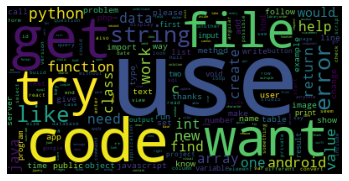

In [96]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud().generate_from_frequencies(freq_dict)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Выведем Топ-10 самых часто встречаемых слов.

In [97]:
sorted(freq_dict.items(), key=lambda x: x[1], reverse = True)[:10]

[('use', 37654),
 ('code', 23625),
 ('get', 21877),
 ('want', 18013),
 ('try', 17982),
 ('file', 17973),
 ('string', 16499),
 ('error', 16179),
 ('like', 15506),
 ('python', 15405)]

Самыми часто встречаемыми словами являются: `use`, `code`, `get`, `want` и `try`. В принципе, слова отражают суть вопросов на сайтах.

Создадим новые датафреймы, которые будут содержать тексты без мусора. Три колонки объединим в одну: `Text`. Колонку `target` переименуем в `our_target`, так как в one-hot encoding может появиться другая колонка `target`.

In [101]:
d = {'Text':pd.Series(strings_body_train) + ' ' + pd.Series(strings_tags_train) + ' ' + pd.Series(strings_title_train),
     'our_target': train.reset_index().target}

new_train = pd.DataFrame(d)
new_train.head()

,Text,our_target
0,algorithmm input graph output set begin null v...,2
1,convert data frame date get convert number kee...,2
2,easy one somehow find solution panda dataframe...,0
3,let say component angular need load different ...,0
4,set var use compile code error find compilatio...,1


In [99]:
new_train.isnull().sum()

Text          0
our_target    0
dtype: int64

In [100]:
d = {'Body': pd.Series(strings_body_train), "Tags": pd.Series(strings_tags_train), "Title": pd.Series(strings_title_train),
'target': train.reset_index().target}

new_train1 = pd.DataFrame(d)
new_train1.head()

,Body,Tags,Title,target
0,algorithmm input graph output set begin null v...,java algorithm graph algorithm,implement minimum span forrest algorihm java s...,2
1,convert data frame date get convert number kee...,html r dataframe,r studio date get converted number make html d...,2
2,easy one somehow find solution panda dataframe...,python panda dataframe pandas groupby,panda dataframe groupby get sum multiple column,0
3,let say component angular need load different ...,angular typescript rxjs,cast result respective type angular,0
4,set var use compile code error find compilatio...,c window batch file,environment variable set batch file cannot acc...,1


In [145]:
d = {"Text":pd.Series(strings_body_test) + ' ' + pd.Series(strings_tags_test) + ' ' + pd.Series(strings_title_test)}

new_test = pd.DataFrame(d)
new_test.head()

,Text
0,give decision tree sample data class solve com...
1,move test application xcode beta convert code ...
2,would like able perform linting jenkins pipeli...
3,use page large link want bypass delay tap mobi...
4,test case want keep run time order please help...


In [103]:
d = {"Body":pd.Series(strings_body_test), "Tags": pd.Series(strings_tags_test), "Title": pd.Series(strings_title_test)}

new_test1 = pd.DataFrame(d)
new_test1.head()

,Body,Tags,Title
0,give decision tree sample data class solve com...,math machine learn artificial intelligence dec...,desecion tree end give tree gain split computa...
1,move test application xcode beta convert code ...,io swift swift3 xcode8 nserror,value type error member code
2,would like able perform linting jenkins pipeli...,jenkins jenkins pipeline,lint jenkins pipeline command line
3,use page large link want bypass delay tap mobi...,javascript cs mobile safari fastclickjs fastclick,way prevent fastclick fire active state scroll
4,test case want keep run time order please help...,android test appium katalon studio,loop test case katalon studio


Сохраним новые датафреймы. 

In [104]:
new_train1.to_csv("new_train1.csv")
new_test1.to_csv("new_test1.csv")

!cp new_train1.csv new_test1.csv "drive/My Drive/Laba_1"

Посмотрим, какие слова чаще всего встречаются в строчках с разными таргетами.

In [105]:
from collections import Counter
import plotly.express as px

In [106]:
def common_words(class_type):

    df = new_train.copy()
    df['temp_list'] = df.Text.apply(lambda x:str(x).split())

    top = Counter([item for sublist in df['temp_list'].loc[df['our_target'] == class_type] for item in sublist])
    top_class = pd.DataFrame(top.most_common(10))
    top_class.columns = ['words','count_words']

    fig = px.bar(top_class, x='count_words', y='words', title=f'Топ-10 самых встречаемых слов класса {class_type}', orientation='h' ,width=800, height=700, color='words')
    fig.show()

In [107]:
common_words(0)

In [108]:
common_words(1)

In [ ]:
common_words(2)

Заметим, что слова `use` и `get` входят в топ-5 каждого из классов.

Можно посмотреть, какие теги присутствуют в качественных постах, а какие - в не очень.

In [109]:
def common_tags(class_type):

    df = new_train.copy()
    df['temp_list'] = pd.Series(strings_tags_train).apply(lambda x:str(x).split())

    top = Counter([item for sublist in df['temp_list'].loc[df['our_target'] == class_type] for item in sublist])
    top_class = pd.DataFrame(top.most_common(5))
    top_class.columns = ['words','count_words']

    fig = px.bar(top_class, x='count_words', y='words', title=f'Топ-5 самых встречаемых тегов класса {class_type}', orientation='h' ,width=800, height=700, color='words')
    fig.show()

In [110]:
common_tags(0)

У качественных постов данные теги самые часто встречаемые. Тег 'android' - самый популярный, т.е. высокую оценку получали вопросы по android-разработке. Вторым по популярности является тег 'python', т.е. вопросы по python-разработке также получали высокую оценку. 

In [111]:
common_tags(1)

Исходя из данного графика, вопросы по c, python, javascript -разработке часто сформулированны неграмотно либо неуместно.

In [112]:
common_tags(2)

Исходя из данного графика, вопросы по c, python, android -разработкам часто сформулированны неграмотно либо неуместно.

### Embeddings

Для дальнейшей работы с текстовыми данными нам нужно эти данные подготовить. Слова должны быть закодированы как целые числа или значения с плавающей запятой (векторизация), либо должен быть использован one-hot encoding.

#### One-hot encoding 

In [113]:
words = [key for key, value in sorted(freq_dict.items(), key=lambda x: x[1], reverse = True)]

In [114]:
def one_hot_encoding(dataset, most_popular_tags):
  df = dataset.copy()

  for i in most_popular_tags:
    df[i] =  pd.Series(np.zeros((len(df))), index=df.index)

  for i, row in df.iterrows():
    current_words = row['Text'].split(" ")
    for j in current_words:
      if j in df.columns:
        df[j][i] = 1

  return df

In [116]:
t = time.time()
train_one_hot = one_hot_encoding(new_train, words[:1000])
print(time.time()-t)

129.97716760635376


In [117]:
train_one_hot.drop(['Text'], axis = 1, inplace = True)
train_one_hot.head()

,our_target,use,code,get,want,try,file,string,error,like,python,work,new,c,value,android,function,data,array,need,help,java,int,return,create,class,find,one,would,javascript,make,way,run,number,know,public,name,list,user,please,...,modal,blank,checkbox,theme,keyword,usage,hit,publish,haskell,filename,efficient,later,pair,mistake,screenshot,reset,pip,goal,adapter,somebody,shape,pop,hold,widget,tkinter,role,promise,constraint,overflow,decide,backend,wrap,err,buffer,visible,emulator,combination,maximum,driver,general
0,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
t = time.time()
test_one_hot = one_hot_encoding(new_test, words[:1000])
print(time.time()-t)

32.49996829032898


In [119]:
test_one_hot.drop(['Text'], axis = 1, inplace = True)
test_one_hot.head()

,use,code,get,want,try,file,string,error,like,python,work,new,c,value,android,function,data,array,need,help,java,int,return,create,class,find,one,would,javascript,make,way,run,number,know,public,name,list,user,please,app,...,modal,blank,checkbox,theme,keyword,usage,hit,publish,haskell,filename,efficient,later,pair,mistake,screenshot,reset,pip,goal,adapter,somebody,shape,pop,hold,widget,tkinter,role,promise,constraint,overflow,decide,backend,wrap,err,buffer,visible,emulator,combination,maximum,driver,general
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Word2Vec

##### Обученная модель

In [120]:
from gensim.models import Word2Vec
import gensim.downloader as api

In [121]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [122]:
def get_word2vec_vectors(corpus, model):    
    
    def get_vector(sentence):   
        word_tokens = word_tokenize(" ".join(sentence))
        vector = 0
        for w in word_tokens:
            try: 
                vector += model.wv[w]
            except:
                continue
        return vector
    
    out_corpus = np.stack(corpus.apply(lambda x: get_vector(x)).to_numpy())
    
    return out_corpus

In [ ]:
w2v = api.load('word2vec-google-news-300')

In [ ]:
train_word2vec = get_word2vec_vectors(new_train['Text'], w2v)
test_word2vec = get_word2vec_vectors(new_test['Text'], w2v)

##### Наша модель

In [ ]:
t = time.time()

our_w2v = Word2Vec(min_count=100, 
                   size=300,  
                   window=5)

our_w2v.build_vocab(all_texts, progress_per=10000)

our_w2v.train(all_texts, total_examples=our_w2v.corpus_count, epochs=our_w2v.epochs, report_delay=1)

print(time.time()-t)

In [ ]:
train_word2vec_our = get_word2vec_vectors(new_train['Text'], our_w2v)
test_word2vec_our = get_word2vec_vectors(new_test['Text'], our_w2v)

#### FastText

##### Обученная модель

In [ ]:
from gensim.models.fasttext import FastText
from gensim.test.utils import common_texts
from gensim.models import KeyedVectors

In [ ]:
def get_fasttext_vectors(corpus, model):    
    
    def get_vector(sentence):   
        word_tokens = word_tokenize(sentence)
        vector = 0
        for w in word_tokens:
            try: 
                vector += model.wv[w]
            except:
                continue
        return vector
    
    out_corpus = np.stack(corpus.apply(lambda x: get_vector(x)).to_numpy())
    
    return out_corpus

In [ ]:
pretrained_FastText = KeyedVectors.load_word2vec_format(DATA_PATH / 'crawl-300d-2M.vec')

In [ ]:
train_fasttext = get_fasttext_vectors(new_train['Text'], pretrained_FastText)
test_fasttext = get_fasttext_vectors(new_test['Text'], pretrained_FastText)

##### Наша модель

In [ ]:
fasttext_train_samples = new_train['Text'].to_list()
fasttext_train_samples = [x.split(' ') for x in fasttext_train_samples]

In [ ]:
fasttext_test_samples = new_test['Text'].to_list()
fasttext_test_samples = [x.split(' ') for x in fasttext_test_samples]

In [ ]:
fasttext_sentences = fasttext_train_samples + fasttext_test_samples

In [ ]:
t = time.time()

our_FastText = FastText(size=200)

our_FastText.build_vocab(sentences = fasttext_sentences)

our_FastText.train(
    sentences=fasttext_sentences, epochs=our_FastText.epochs,
    total_examples=our_FastText.corpus_count, total_words=our_FastText.corpus_total_words
)

print(our_FastText)
print(time.time()-t)

In [ ]:
train_fasttext_our = get_fasttext_vectors(new_train['Text'], our_FastText)
test_fasttext_our = get_fasttext_vectors(new_test['Text'], our_FastText)

#### TF-IDF

In [123]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [124]:
tf_idf = TfidfVectorizer()

tf_idf.fit(new_train.merge(new_test, how='outer').Text)

train_tf_idf = tf_idf.transform(new_train['Text'])
test_tf_idf = tf_idf.transform(new_test['Text'])

In [125]:
train_tf_idf.shape, test_tf_idf.shape

((47555, 45527), (11882, 45527))

### ML - algorithms

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy import sparse

In [ ]:
y = new_train['our_target']

In [ ]:
embeddings = {'tf_idf': train_test_split(train_tf_idf, y, test_size=0.2, random_state=2020),
              'word2vec': train_test_split(train_word2vec, y, test_size=0.2, random_state=2020),
              'our_word2vec': train_test_split(train_word2vec_our, y, test_size=0.2, random_state=2020),
              'fasttext': train_test_split(train_fasttext, y, test_size=0.2, random_state=2020),
              'our_fasttext': train_test_split(train_fasttext_our, y, test_size=0.2, random_state=2020),
              'one_hot': train_test_split(train_one_hot.drop(['our_target'], axis=1), y, test_size=0.2, random_state=2020)}

Дальше возможны вылеты из-за того, что памяти недостаточно. Поэтому сохраним наши файлы на диск, чтобы в дальнейшем сразу их загружать и работать с ними.

In [ ]:
embeddings2 = {}

In [ ]:
data = train_test_split(train_tf_idf, y, test_size=0.2, random_state=2020)

sparse.save_npz("X_train_tf_idf.npz", data[0])
sparse.save_npz("X_val_tf_idf.npz", data[1])
data[2].to_csv('y_train_tf_idf.csv')
data[3].to_csv('y_val_tf_idf.csv')

!cp X_train_tf_idf.npz X_val_tf_idf.npz y_train_tf_idf.csv y_val_tf_idf.csv "drive/My Drive/Laba_1/tf_idf"

In [ ]:
data = train_test_split(train_word2vec, y, test_size=0.2, random_state=2020)

np.savetxt('X_train_word2vec.txt', data[0])
np.savetxt('X_val_word2vec.txt', data[1])
data[2].to_csv('y_train_word2vec.csv')
data[3].to_csv('y_val_word2vec.csv')

!cp X_train_word2vec.txt X_val_word2vec.txt y_train_word2vec.csv y_val_word2vec.csv "drive/My Drive/Laba_1/word2vec"

In [ ]:
data = train_test_split(train_word2vec_our, y, test_size=0.2, random_state=2020)

np.savetxt('X_train_our_word2vec.txt', data[0])
np.savetxt('X_val_our_word2vec.txt', data[1])
data[2].to_csv('y_train_our_word2vec.csv')
data[3].to_csv('y_val_our_word2vec.csv')

!cp X_train_our_word2vec.txt X_val_our_word2vec.txt y_train_our_word2vec.csv y_val_our_word2vec.csv "drive/My Drive/Laba_1/our_word2vec"

In [ ]:
data = train_test_split(train_fasttext, y, test_size=0.2, random_state=2020)

np.savetxt('X_train_fasttext.txt', data[0])
np.savetxt('X_val_fasttext.txt', data[1])
data[2].to_csv('y_train_fasttext.csv')
data[3].to_csv('y_val_fasttext.csv')

!cp X_train_fasttext.txt X_val_fasttext.txt y_train_fasttext.csv y_val_fasttext.csv "drive/My Drive/Laba_1/fasttext"

In [ ]:
data = train_test_split(train_fasttext_our, y, test_size=0.2, random_state=2020)

np.savetxt('X_train_our_fasttext.txt', data[0])
np.savetxt('X_val_our_fasttext.txt', data[1])
data[2].to_csv('y_train_our_fasttext.csv')
data[3].to_csv('y_val_our_fasttext.csv')

!cp X_train_our_fasttext.txt X_val_our_fasttext.txt y_train_our_fasttext.csv y_val_our_fasttext.csv "drive/My Drive/Laba_1/our_fasttext"

In [ ]:
data = train_test_split(train_one_hot.drop(['our_target'], axis=1), train_one_hot['our_target'], test_size=0.2, random_state=2020)

data[0].to_csv('X_train_one_hot.csv')
data[1].to_csv('X_val_one_hot.csv')
data[2].to_csv('y_train_one_hot.csv')
data[3].to_csv('y_val_one_hot.csv')

!cp X_train_one_hot.csv X_val_one_hot.csv y_train_one_hot.csv y_val_one_hot.csv "drive/My Drive/Laba_1/one_hot"

In [ ]:
t=time.time()
embeddings2['one_hot'] = [pd.read_csv(DATA_PATH / 'one_hot/X_train_one_hot.csv', index_col = 'Unnamed: 0'), pd.read_csv(DATA_PATH / 'one_hot/X_val_one_hot.csv', index_col = 'Unnamed: 0'), pd.read_csv(DATA_PATH / 'one_hot/y_train_one_hot.csv', index_col = 'Unnamed: 0'), pd.read_csv(DATA_PATH / 'one_hot/y_val_one_hot.csv', index_col = 'Unnamed: 0')]
embeddings2['word2vec'] = [np.loadtxt(DATA_PATH / 'word2vec/X_train_word2vec.txt'), np.loadtxt(DATA_PATH / 'word2vec/X_val_word2vec.txt'), pd.read_csv(DATA_PATH / 'word2vec/y_train_word2vec.csv', index_col = 'Unnamed: 0'), pd.read_csv(DATA_PATH / 'word2vec/y_val_word2vec.csv', index_col = 'Unnamed: 0')]  
embeddings2['our_word2vec'] = [np.loadtxt(DATA_PATH / 'our_word2vec/X_train_our_word2vec.txt'), np.loadtxt(DATA_PATH / 'our_word2vec/X_val_our_word2vec.txt'), pd.read_csv(DATA_PATH / 'our_word2vec/y_train_our_word2vec.csv', index_col = 'Unnamed: 0'), pd.read_csv(DATA_PATH / 'our_word2vec/y_val_our_word2vec.csv', index_col = 'Unnamed: 0')]
embeddings2['fasttext'] = [np.loadtxt(DATA_PATH / 'fasttext/X_train_fasttext.txt'), np.loadtxt(DATA_PATH / 'fasttext/X_val_fasttext.txt'), pd.read_csv(DATA_PATH / 'fasttext/y_train_fasttext.csv', index_col = 'Unnamed: 0'), pd.read_csv(DATA_PATH / 'fasttext/y_val_fasttext.csv', index_col = 'Unnamed: 0')]
embeddings2['our_fasttext'] = [np.loadtxt(DATA_PATH / 'our_fasttext/X_train_our_fasttext.txt'), np.loadtxt(DATA_PATH / 'our_fasttext/X_val_our_fasttext.txt'), pd.read_csv(DATA_PATH / 'our_fasttext/y_train_our_fasttext.csv', index_col = 'Unnamed: 0'), pd.read_csv(DATA_PATH / 'our_fasttext/y_val_our_fasttext.csv', index_col = 'Unnamed: 0')]
embeddings2['tf_idf'] = [sparse.load_npz(DATA_PATH / 'tf_idf/X_train_tf_idf.npz'), sparse.load_npz(DATA_PATH / 'tf_idf/X_val_tf_idf.npz'), pd.read_csv(DATA_PATH / 'tf_idf/y_train_tf_idf.csv', index_col = 'Unnamed: 0'), pd.read_csv(DATA_PATH / 'tf_idf/y_val_tf_idf.csv', index_col = 'Unnamed: 0')]
print(time.time()-t)

Создадим для удобства одну функцию для всех алгоритмов, параметром которой будет выступать непосредственно нужный нам алгоритм.

In [ ]:
def Graph(y_val, y_pred, name):

  plt.figure(figsize=(6,3))
  plt.plot(y_val[1:100].values, 'b-', label='true')
  plt.plot(y_pred[1:100], 'r-', label='pred')

  plt.title(name)
  plt.xlabel("observations")
  plt.ylabel("cnt")

  plt.legend(loc='best')

  plt.show()

In [ ]:
def algorithm(algorithm, name, data):

    t = time.time()

    X_train, X_val, y_train, y_val = data

    model = algorithm.fit(X_train, y_train)
    prediction = model.predict(X_val)
   
    Graph(y_val, prediction, name)

    print(name + ':', accuracy_score(y_val, prediction))
    print('time:', time.time()-t, '\n')

#### SVM

In [ ]:
our_list = ['one_hot', 'word2vec', 'our_word2vec', 'fasttext', 'our_fasttext', 'tf_idf']

In [126]:
from sklearn.svm import SVC

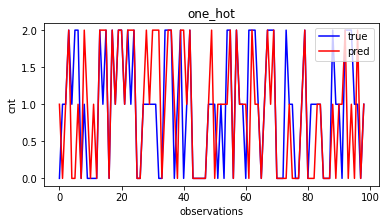

one_hot: 0.7320996740616129
time: 5093.28524184227 



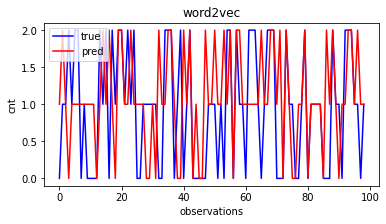

word2vec: 0.4791294290821154
time: 1306.658218383789 



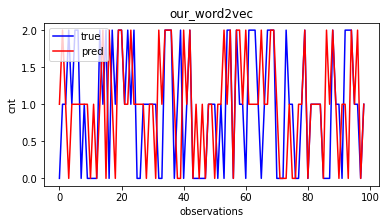

our_word2vec: 0.5105667122279466
time: 1252.096877336502 



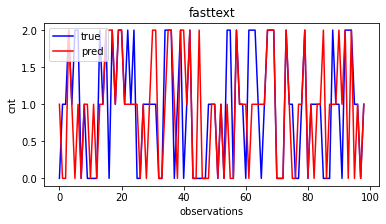

fasttext: 0.72347807801493
time: 797.1481719017029 



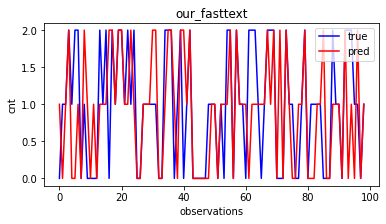

our_fasttext: 0.7331510882136474
time: 563.757232427597 



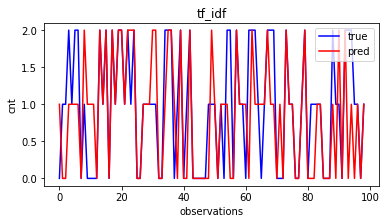

tf_idf: 0.7387235832194301
time: 1598.7187690734863 



In [ ]:
for i in our_list:
  algorithm(SVC(), i, embeddings2[i])

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

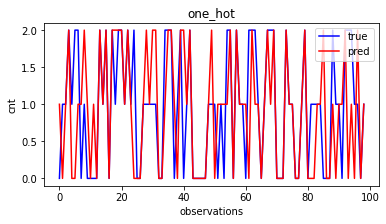

one_hot: 0.7194827042371991
time: 25.662763357162476 



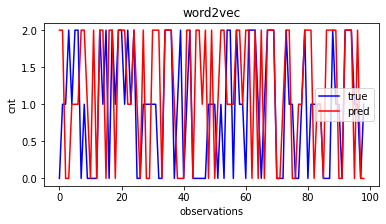

word2vec: 0.46072968142151194
time: 7.42026162147522 



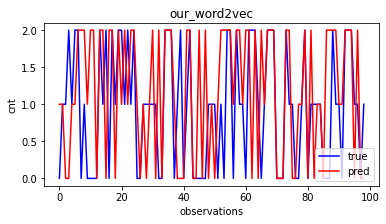

our_word2vec: 0.47849858059089473
time: 7.705506801605225 



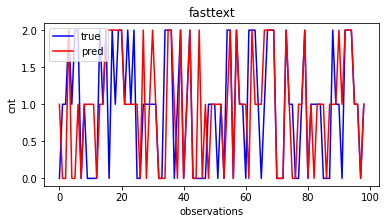

fasttext: 0.7123330880033645
time: 7.296084403991699 



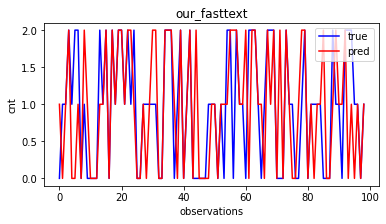

our_fasttext: 0.7086531384712438
time: 5.451042890548706 



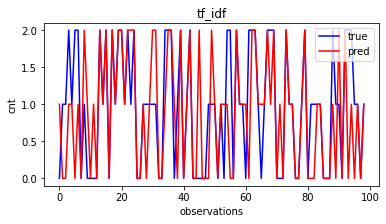

tf_idf: 0.7299968457575439
time: 6.787110805511475 



In [ ]:
for i in our_list:
  algorithm(LogisticRegression(), i, embeddings[i])

#### Random Forest

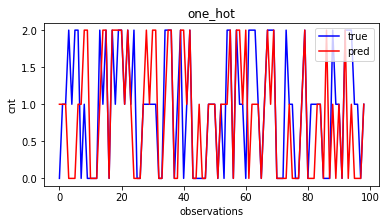

one_hot: 0.7041320576174955
time: 48.05186676979065 



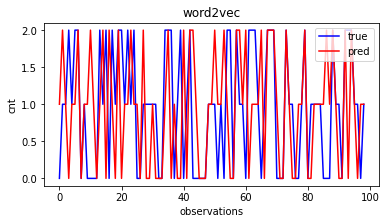

word2vec: 0.4950057827778362
time: 86.96396970748901 



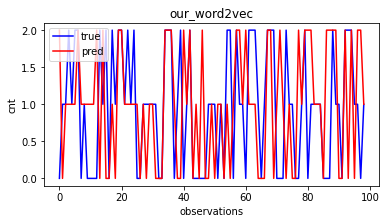

our_word2vec: 0.5025759646724844
time: 87.33464241027832 



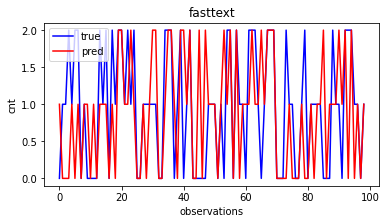

fasttext: 0.6835243402376195
time: 81.21190285682678 



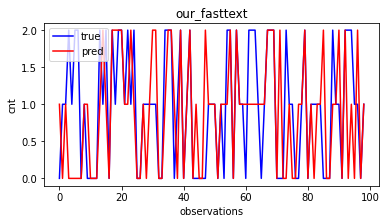

our_fasttext: 0.70213437072863
time: 67.156240940094 



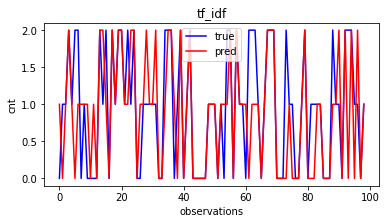

tf_idf: 0.7197981284828093
time: 168.64094996452332 



In [ ]:
from sklearn.ensemble import RandomForestClassifier

for i in our_list:
  algorithm(RandomForestClassifier(), i, embeddings[i])

#### Decision Tree

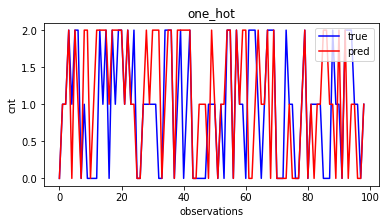

one_hot: 0.5893176322153296
time: 14.65692400932312 



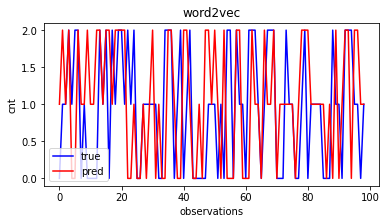

word2vec: 0.39817053937546
time: 25.403537034988403 



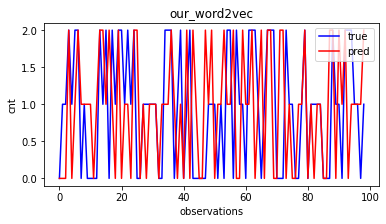

our_word2vec: 0.4051098727788876
time: 24.95843505859375 



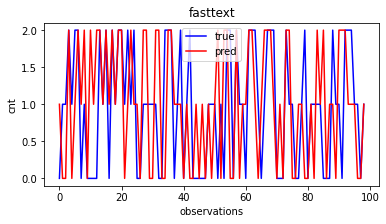

fasttext: 0.51677005572495
time: 23.234206914901733 



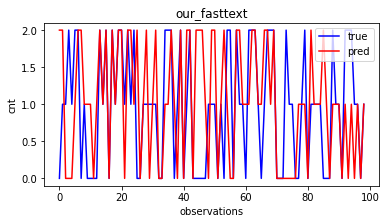

our_fasttext: 0.5663968037009778
time: 17.937044620513916 



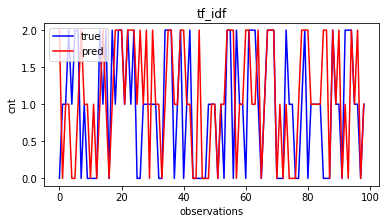

tf_idf: 0.5792240563557985
time: 33.07052516937256 



In [ ]:
from sklearn.tree import DecisionTreeClassifier

for i in our_list:
  algorithm(DecisionTreeClassifier(), i, embeddings2[i])

Мы выбрали следующие boosting алгоритмы: XGBoost, AdaBoost и CatBoost.

C точки зрения скорости и точности CatBoost должен выигрывать (только тогда, когда у нас есть категориальные переменные в данных и мы их правильно настраиваем).

Точность XGBoost должна быть близка к CatBoost, но он слишком медленный(особенно настройка параметров).

AdaBoost был взят для сравнения результатов.

#### XGBoost

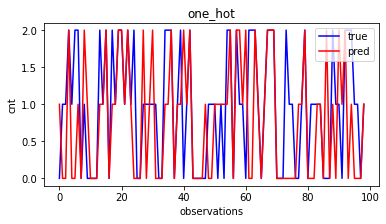

one_hot: 0.6684891178635265
time: 228.5780701637268 



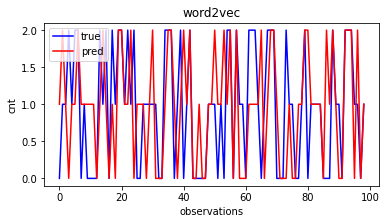

word2vec: 0.49574177268426034
time: 219.3076469898224 



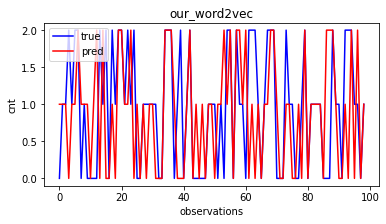

our_word2vec: 0.511618126379981
time: 221.26357698440552 



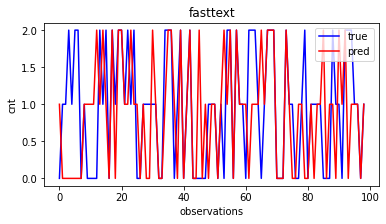

fasttext: 0.6861528756177058
time: 237.77206873893738 



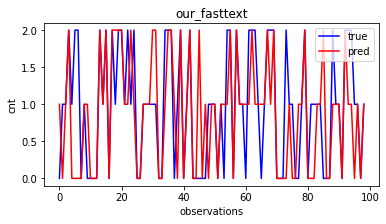

our_fasttext: 0.704237199032699
time: 156.8193085193634 



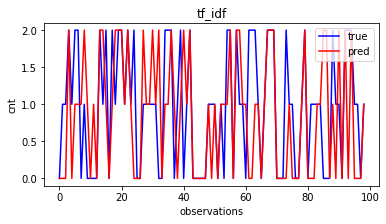

tf_idf: 0.6660708653138471
time: 51.50137948989868 



In [ ]:
import xgboost as xgb

for i in our_list:
  algorithm(xgb.XGBClassifier(), i, embeddings2[i])

#### AdaBoost

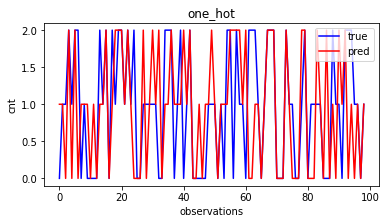

one_hot: 0.6471454105772264
time: 20.436318159103394 



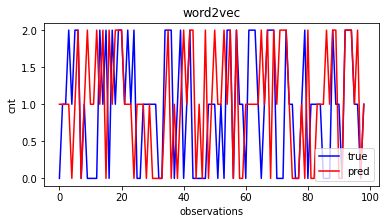

word2vec: 0.46956156029860163
time: 107.86078691482544 



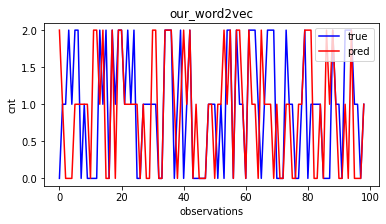

our_word2vec: 0.48144254021659133
time: 111.52643489837646 



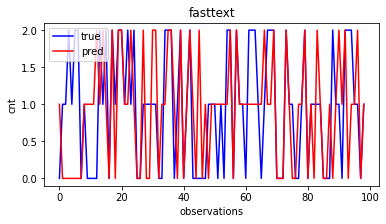

fasttext: 0.6350541478288297
time: 110.23921370506287 



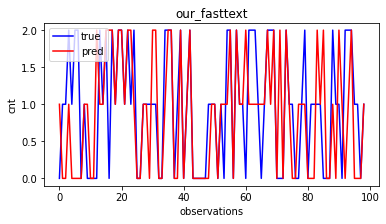

our_fasttext: 0.6603932288928609
time: 73.40550398826599 



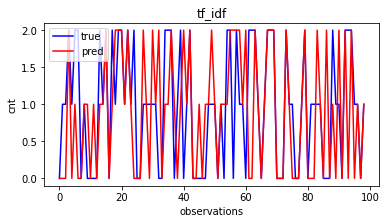

tf_idf: 0.6387340973609504
time: 63.06692028045654 



In [ ]:
from sklearn.ensemble import AdaBoostClassifier

for i in our_list:
  algorithm(AdaBoostClassifier(), i, embeddings2[i])

#### CatBoost

In [ ]:
pip install catboost

     |████████████████████████████████| 66.3MB 78kB/s 


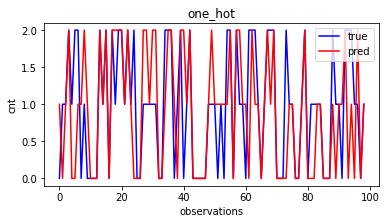

one_hot: 0.7235832194301335
time: 172.46149587631226 



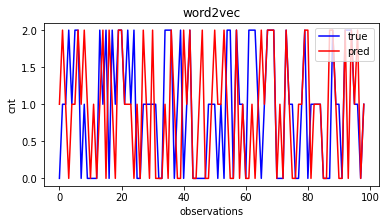

word2vec: 0.5191883082746294
time: 350.09528398513794 



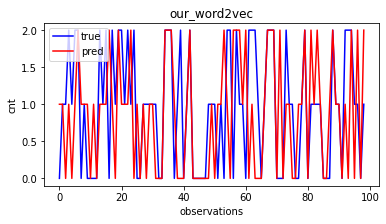

our_word2vec: 0.5308590053622122
time: 352.6168284416199 



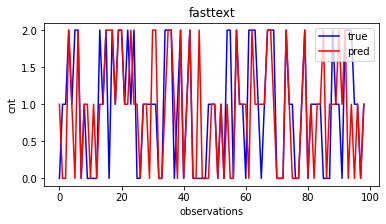

fasttext: 0.7212701082956576
time: 367.3741545677185 



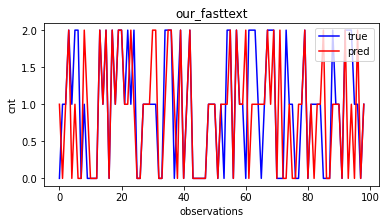

our_fasttext: 0.7298917043423404
time: 256.5928363800049 



In [ ]:
from catboost import CatBoostClassifier

our_list = ['one_hot', 'word2vec', 'our_word2vec', 'fasttext', 'our_fasttext']

for i in our_list: 
  algorithm(CatBoostClassifier(logging_level='Silent'), i, embeddings2[i])

Как мы и предполагали, CatBoost дал лучшую точность(≈0.73 - наивысшая точность CatBoost) по сравнению с XGBoost и AdaBoost(худший результат), но CatBoost проиграл с точки зрения времени по сравнению с XGBoost и AdaBoost. 

### Grid Search

In [ ]:
import time
from sklearn.model_selection import  GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

Random Forest

In [ ]:
X_train, X_val, y_train, y_val = embeddings2['our_fasttext']
t = time.time()
param_grid={'max_depth': [None, 3, 5], 
             'criterion': ['gini', 'entropy'],
             'min_samples_split': [2, 4, 6],
              'n_estimators': [50, 100, 150]}
gs = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1)
gs.fit(X_train, y_train)

print(gs.best_params_, gs.best_score_)

print(time.time()-t)

{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 150} 0.7023446520453738
8665.156713485718


In [ ]:
X_train, X_val, y_train, y_val = embeddings2['tf_idf']
t = time.time()
param_grid={'max_depth': [None, 1, 2, 3, 4, 5], 
             'criterion': ['gini', 'entropy'],
             'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [1, 2, 3], 
              'n_estimators': [50, 100, 150]}
gs = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1)
gs.fit(X_train, y_train)

print(gs.best_params_, gs.best_score_)

print(time.time()-t)
#{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 150} 0.7163022675427668
#7697.834757804871

Logistic Regression

In [ ]:
X_train, X_val, y_train, y_val = embeddings2['tf_idf']
t = time.time()
param_grid={'penalty': ['l1', 'l2', 'elasticnet', 'none'],'C':[0.001,.009,0.01,.09,1,5,10,25],'random_state' : [2020]}
gs = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, n_jobs=-1)
gs.fit(X_train, y_train)

print(gs.best_params_, gs.best_score_)

print(time.time()-t)

{'C': 1, 'penalty': 'l2', 'random_state': 2020} 0.7222952639653164
1557.4532632827759


In [ ]:
X_train, X_val, y_train, y_val = embeddings2['one_hot']
t = time.time()
param_grid={'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25],'random_state' : [2020]}
gs = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, n_jobs=-1)
gs.fit(X_train, y_train)

print(gs.best_params_, gs.best_score_)

print(time.time()-t)

{'C': 0.09, 'penalty': 'l2', 'random_state': 2020} 0.7159078697690308
941.0804789066315


In [ ]:
X_train, X_val, y_train, y_val = embeddings2['fasttext']
t = time.time()
param_grid={'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25],'random_state' : [2020]}
gs = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, n_jobs=-1)
gs.fit(X_train, y_train)

print(gs.best_params_, gs.best_score_)

print(time.time()-t)

{'C': 0.001, 'penalty': 'l2', 'random_state': 2020} 0.7128850920771641
655.8994212150574


In [ ]:
X_train, X_val, y_train, y_val = embeddings2['our_fasttext']
t = time.time()
param_grid={'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25],'random_state' : [2020]}
gs = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, n_jobs=-1)
gs.fit(X_train, y_train)

print(gs.best_params_, gs.best_score_)

print(time.time()-t)

{'C': 1, 'penalty': 'l2', 'random_state': 2020} 0.7190620120425768
1144.5943744182587


Таким образом, лучшие результаты показали следующие алгоритмы:
- SVM with One-hot,TF-IDF, FastText(обученная модель и наша)
- Logistic Regression with TF-IDF
- Random Forest with TF-IDF
- CatBoost with One-hot, FastText(обученная модель и наша)

Лучший результат составил ≈0.739 (алгоритм SVM with TF-IDF).

Подбор параметров с помощью GridSearch не дал особых улучшений.

Предположительно, причина того, что accuracy маленькая - это использование нами всего текста. Можно было бы попробовать использовать только теги.


### Нейронные сети

In [ ]:
new_train1 = pd.read_csv(DATA_PATH / 'new_train1.csv', index_col = 'Unnamed: 0')
new_test1 = pd.read_csv(DATA_PATH / 'new_test1.csv', index_col = 'Unnamed: 0')

In [ ]:
new_train1['Body'] = new_train1.Body.astype('str')
new_train1['Tags'] = new_train1.Body.astype('str')
new_train1['Title'] = new_train1.Body.astype('str')

In [ ]:
from collections import Counter

text_columns = ['Body', 'Tags', 'Title']

token_counts = Counter(token for col in text_columns
                             for item in new_train1[col]
                             for token in item.split())

token_counts['get']

44418

In [ ]:
len(token_counts)

34953

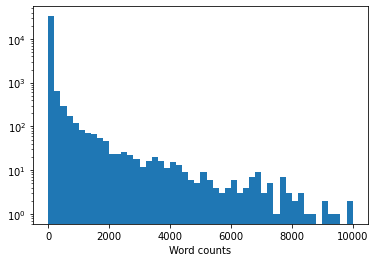

In [ ]:
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

In [ ]:
min_count = 10

tokens = [token for token, count in token_counts.items()
          if count >= min_count]

In [ ]:
print("Vocabulary size:", len(tokens))

Vocabulary size: 10384


In [ ]:
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)

token_to_id = dict(map(reversed, enumerate(tokens)))

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [ ]:
print("Lines:")
print('\n'.join(new_train1["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(new_train1["Title"][::100000]))

Lines:
algorithmm input graph output set begin null vertex create tree single vertex add end repeat find edge minimum weight one end belong end belongs tree add stuck logic highlight block use simple object vertex edge tree set use array object

Matrix:
[[   0 4521 3919 6350 8053  882 6085 9772 2021 9321 8217 9772  151 2951
  7500 3443 2803 5623 9977 6228 2951  899 2951  900 9321  151 8649 5271
  4136  999 9637 8192 6132 9772 2803 9321 8053 9637  554 6132]]


In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(new_train1, test_size=0.2, random_state=2020)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  38044
Validation size =  9511


In [ ]:
target_column = 'target'

In [ ]:
def make_batch(data, max_len=None, word_dropout=0):
   
    batch = {}
    batch["Body"] = as_matrix(data["Body"].values, max_len)
    batch["Tags"] = as_matrix(data["Tags"].values, max_len)
    batch['Title'] = as_matrix(data["Title"].values, max_len)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [ ]:
import keras
import keras.layers as L

In [ ]:
def build_model(n_tokens=len(tokens), hid_size=64):
    
    l_title = L.Input(shape=[None], name="Title")
    l_body = L.Input(shape=[None], name="Body")
    l_tags = L.Input(shape=[None], name="Tags")
    
    emb = L.Embedding(len(tokens), 64)
    l_title_emb = emb(l_title)
    l_title_emb = L.Dense(128)(l_title_emb)
    l_title_emb = L.GlobalMaxPool1D()(l_title_emb)

    l_body_emb = emb(l_body)
    l_body_emb = L.Dense(256)(l_body_emb)
    l_body_emb = L.GlobalMaxPool1D()(l_body_emb)

    l_tags_emb = emb(l_tags)
    l_tags_emb = L.Dense(128)(l_tags_emb)
    l_tags_emb = L.GlobalMaxPool1D()(l_tags_emb)

    l_all = L.Concatenate()([l_title_emb, l_body_emb, l_tags_emb])
    l_all = L.Dense(128)(l_all)
    output_layer = L.Dense(1)(l_all)
    
    model = keras.models.Model(inputs=[l_title, l_body, l_tags], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error','accuracy'])
    return model

In [ ]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

In [ ]:
batch_size = 256
epochs = 50            
steps_per_epoch = 100  

model = build_model()

model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size)

Epoch 1/50
100/100 [==============================] - 57s 566ms/step - loss: 0.5069 - mean_absolute_error: 0.5877 - accuracy: 0.3826 - val_loss: 0.3546 - val_mean_absolute_error: 0.4749 - val_accuracy: 0.4841
Epoch 2/50
100/100 [==============================] - 56s 558ms/step - loss: 0.3249 - mean_absolute_error: 0.4526 - accuracy: 0.4781 - val_loss: 0.3392 - val_mean_absolute_error: 0.4634 - val_accuracy: 0.4791
Epoch 3/50
100/100 [==============================] - 59s 588ms/step - loss: 0.2975 - mean_absolute_error: 0.4284 - accuracy: 0.5010 - val_loss: 0.3250 - val_mean_absolute_error: 0.4502 - val_accuracy: 0.4901
Epoch 4/50
100/100 [==============================] - 55s 546ms/step - loss: 0.2541 - mean_absolute_error: 0.3920 - accuracy: 0.5243 - val_loss: 0.3333 - val_mean_absolute_error: 0.4528 - val_accuracy: 0.4940
Epoch 5/50
100/100 [==============================] - 63s 628ms/step - loss: 0.2360 - mean_absolute_error: 0.3751 - accuracy: 0.5333 - val_loss: 0.3481 - val_mean_a

In [ ]:
def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = model.predict(batch_x)[:, 0]
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error
    
print_metrics(model, data_train, name='Train')
print_metrics(model, data_val, name='Val');

Train results:
Mean square error: 0.01696
Mean absolute error: 0.09688
Val results:
Mean square error: 0.40844
Mean absolute error: 0.49781


Результаты нейронной сети оказались хуже, чем результаты ML-алгоритмов, лучшее значение не изменилось.

Лучшим оказался алгоритм SVM. Метод Опорных Векторов или SVM — это линейный алгоритм, используемый в задачах классификации и регрессии. Основной задачей алгоритма является найти наиболее правильную линию, или гиперплоскость разделяющую данные на два класса. SVM это алгоритм, который получает на входе данные, и возвращает такую разделяющую линию.

### Предсказание меток классов

In [129]:
t = time.time()

model = SVC().fit(train_tf_idf, new_train['our_target'])
prediction = model.predict(test_tf_idf)

print(time.time()-t)

2293.9039232730865


In [130]:
prediction

array([2, 0, 0, ..., 0, 1, 1])

In [131]:
new_test.head()

,Text
0,give decision tree sample data class solve com...
1,move test application xcode beta convert code ...
2,would like able perform linting jenkins pipeli...
3,use page large link want bypass delay tap mobi...
4,test case want keep run time order please help...


In [146]:
new_test['Predicted'] = pd.Series(prediction)

new_test.head()

,Text,Predicted
0,give decision tree sample data class solve com...,2
1,move test application xcode beta convert code ...,0
2,would like able perform linting jenkins pipeli...,0
3,use page large link want bypass delay tap mobi...,0
4,test case want keep run time order please help...,2


In [147]:
new_test.drop(['Text'], axis=1).to_csv("test.csv")

In [148]:
!cp test.csv "drive/My Drive/Laba_1"